# **SKENARIO UJI COBA 2**

Klasifikasi citra USG payudara dengan arsitektur **ResNet152v2** dengan jumlah data asli, jumlah epoch sebanyak 50.

## **Persiapan Data**

Mengimpor Library dan Module yang dibutuhkan

In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
from google.colab import drive

Menghubungkan Google Colab dengan Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Mengakses dataset dari Google Drive

In [ ]:
#Path file dataset
base_dir = '/content/drive/MyDrive/Dataset_Skripsi/Dataset_Breast_Ultrasound/data'

#Menentukan direktori data training
train_dir = os.path.join(base_dir, 'train')

train_benign = train_dir+'/benign'
train_malignant = train_dir+'/malignant'
train_normal = train_dir+'/normal'

#Menentukan direktori data testing
test_dir = os.path.join(base_dir, 'test')

test_benign = test_dir+'/benign'
test_malignant =test_dir+'/malignant'
test_normal = test_dir+'/normal'

#Menghitung total data train
print('total citra train:', len(os.listdir(train_benign))+
                            len(os.listdir(train_malignant))+
                            len(os.listdir(train_normal))
                            )
#Menghitung total data test
print('total citra test:', len(os.listdir(test_benign))+
                           len(os.listdir(test_malignant))+
                           len(os.listdir(test_normal)))

total citra train: 701
total citra test: 79


## **Pemrosesan Citra**

### **Resize**

Mengatur ukuran citra dan batch_size

In [ ]:
image_height = image_width = 224
batch_size = 16

Melakukan resize citra data train menjadi 224x224

In [ ]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(image_height, image_width)
  )

Found 701 files belonging to 3 classes.


Melihat daftar kelas pada dataset

In [ ]:
class_names = data_train.class_names
print(class_names)

['benign', 'malignant', 'normal']


Visualisasi hasil resize

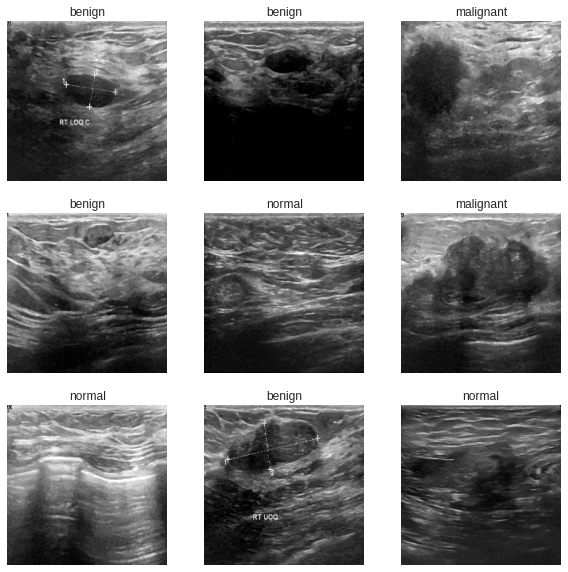

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Melakukan resize citra data test menjadi 224x224

In [ ]:
data_test = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(image_height, image_width)
  )

Found 79 files belonging to 3 classes.


In [ ]:
class_names = data_test.class_names
print(class_names)

['benign', 'malignant', 'normal']


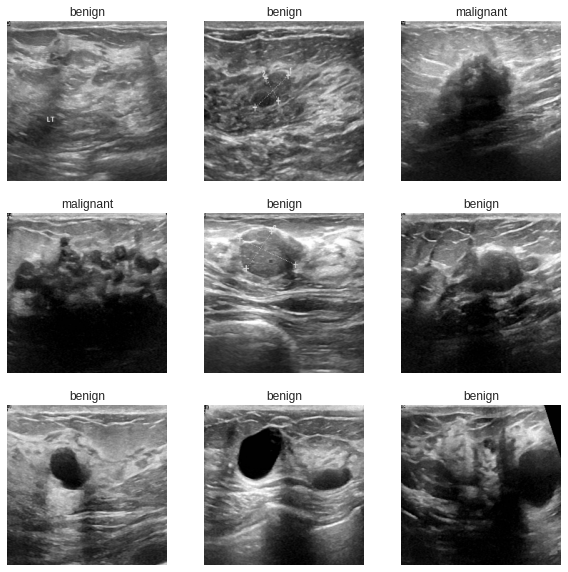

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in data_test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### **Pembagian Data & Augmentasi**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.4,1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.15
                                   )
    
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.15
                                        )
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='training',
    seed = 123,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='validation',
    seed = 123,
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123,
    shuffle = False
)

Found 598 images belonging to 3 classes.
Found 103 images belonging to 3 classes.
Found 79 images belonging to 3 classes.


## **Perancangan CNN**

In [ ]:
from keras import regularizers
tf.keras.backend.clear_session()

from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.regularizers import L2

model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(image_height, image_width, 3))),
    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)), 
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  
])
model.layers[0].trainable = False
model.summary()

234545216/234545216 [==============================] - 11s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         9437696   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)              

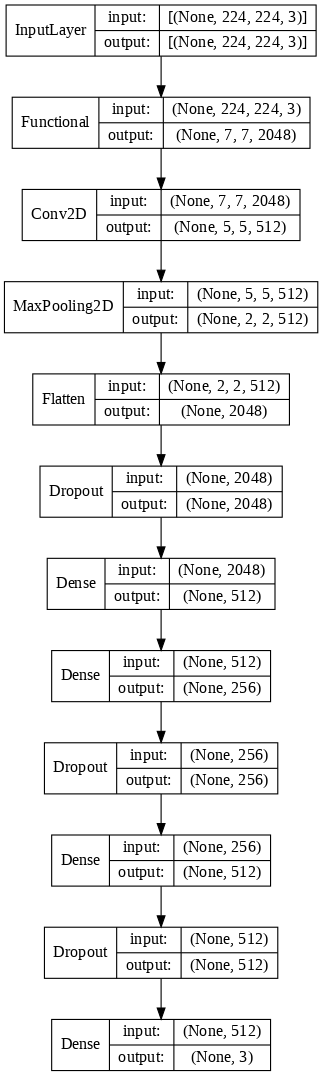

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

## **Training Model**

In [ ]:
import keras

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
%%time
history = model.fit(train_generator, 
                    epochs=50,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr, lr_scheduler],
                    shuffle = True)

Epoch 1/50
38/38 [==============================] - 87s 2s/step - loss: 4.4678 - accuracy: 0.4883 - specificity_at_sensitivity: 0.7333 - sensitivity_at_specificity: 0.7074 - val_loss: 2.2528 - val_accuracy: 0.6311 - val_specificity_at_sensitivity: 0.9078 - val_sensitivity_at_specificity: 0.9515 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - 15s 388ms/step - loss: 2.4371 - accuracy: 0.5485 - specificity_at_sensitivity: 0.8110 - sensitivity_at_specificity: 0.7742 - val_loss: 2.1032 - val_accuracy: 0.6408 - val_specificity_at_sensitivity: 0.9272 - val_sensitivity_at_specificity: 0.9612 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - 15s 399ms/step - loss: 2.0816 - accuracy: 0.6137 - specificity_at_sensitivity: 0.8838 - sensitivity_at_specificity: 0.8930 - val_loss: 1.8769 - val_accuracy: 0.7282 - val_specificity_at_sensitivity: 0.9757 - val_sensitivity_at_specificity: 0.9806 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - 15s 389ms/step 

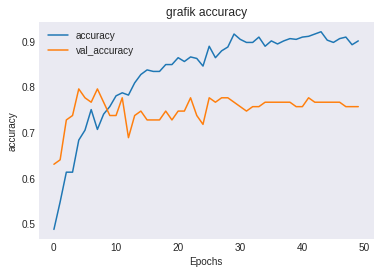

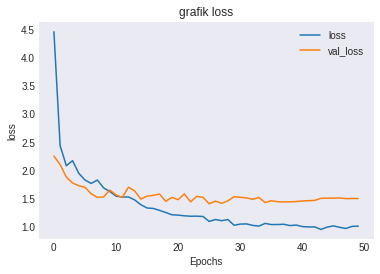

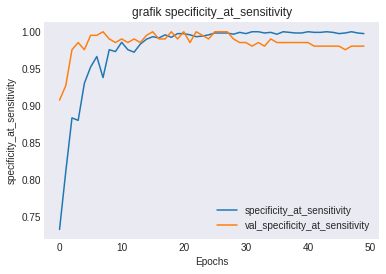

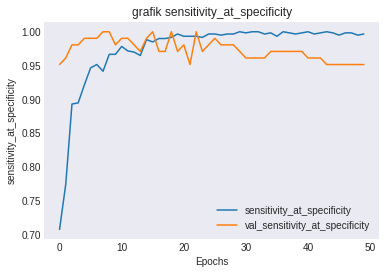

In [ ]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
grafik_plot(history, "accuracy")
grafik_plot(history, "loss")
grafik_plot(history, "specificity_at_sensitivity")
grafik_plot(history, "sensitivity_at_specificity")

## **Testing**

In [ ]:
true_labels = test_generator.classes
prob_test = model.predict(test_generator)
predictions = prob_test.argmax(axis=1)

print('Label Sebenarnya : ', true_labels)
print('Label Prediksi : ', predictions)

test_model = model.evaluate(test_generator, verbose=1)

5/5 [==============================] - 4s 392ms/step
Label Sebenarnya :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]
Label Prediksi :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 2 1 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 2 2 2 2 2 2 0 0 2
 2 2 2 1 0]
5/5 [==============================] - 1s 179ms/step - loss: 1.3521 - accuracy: 0.8228 - specificity_at_sensitivity: 0.9873 - sensitivity_at_specificity: 0.9747


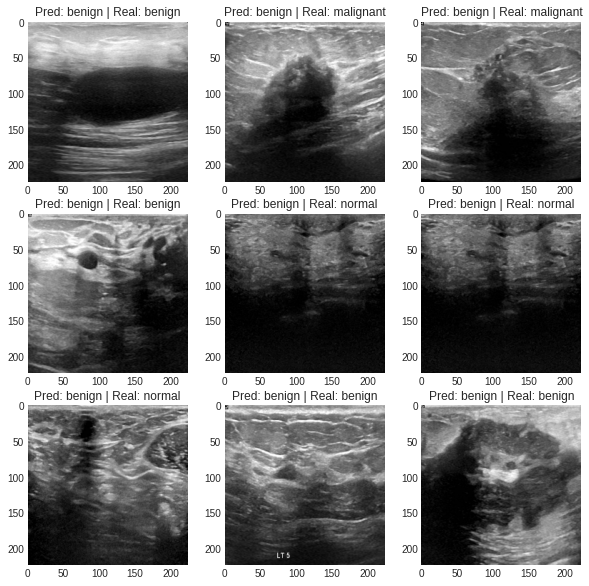

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in data_test.take(1):
  classifications = model(images)
  
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [ ]:
print(train_generator.class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 224, 224, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  kelas = ['benign', 'malignant', 'normal']
  df['Kelas'] = kelas
  df = df[['Kelas', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_class = 'benign'
  elif predict_label == 1:
      predict_class = 'malignant'
  else:
      predict_class = 'normal'

  return predict_class, df

Saving malignant (3).png to malignant (3).png
1/1 [==============================] - 0s 32ms/step




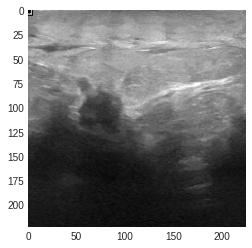


Citra dikenali sebagai malignant


       Kelas  Probability
0     benign     0.002766
1  malignant     0.997197
2     normal     0.000037




In [ ]:
from keras_preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nCitra dikenali sebagai " + label)
print('\n')
print(df)
print('\n')

## **Evaluasi**

In [ ]:
#Evaluasi loss, akurasi, specificity, sensitivity pada train data
loss, accuracy, specificity, sensitivity = model.evaluate(train_generator)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

38/38 [==============================] - 13s 348ms/step - loss: 0.9216 - accuracy: 0.9398 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000
Loss train set:  0.921649158000946
Akurasi train set:  0.9397993087768555
Specificity train set:  1.0
Sensitivity train set:  1.0


In [ ]:
#Evaluasi loss, akurasi, specificity, sensitivity pada validation data
val_loss, val_accuracy, val_specificity, val_sensitivity = model.evaluate(validation_generator)
print('Loss validation set: ', val_loss)
print('Akurasi validation set: ', val_accuracy)
print('Specificity validation set: ', val_specificity)
print('Sensitivity validation set: ', val_sensitivity)

7/7 [==============================] - 1s 166ms/step - loss: 1.4967 - accuracy: 0.7573 - specificity_at_sensitivity: 0.9806 - sensitivity_at_specificity: 0.9515
Loss validation set:  1.496706485748291
Akurasi validation set:  0.7572815418243408
Specificity validation set:  0.9805825352668762
Sensitivity validation set:  0.9514563083648682


In [ ]:
#Evaluasi loss, akurasi, specificity, sensitivity pada test data
test_loss, test_accuracy, test_specificity, test_sensitivity = model.evaluate(test_generator)
print('Loss test set: ', test_loss)
print('Akurasi test set: ', test_accuracy)
print('Specificity test set: ', test_specificity)
print('Sensitivity test set: ', test_sensitivity)

5/5 [==============================] - 1s 178ms/step - loss: 1.3521 - accuracy: 0.8228 - specificity_at_sensitivity: 0.9873 - sensitivity_at_specificity: 0.9747
Loss test set:  1.3520900011062622
Akurasi test set:  0.8227847814559937
Specificity test set:  0.9873417615890503
Sensitivity test set:  0.9746835231781006


In [ ]:
prediction= model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=2)
prediction= (prediction > 0.5)
val_labels=test_generator.classes

5/5 - 1s - 878ms/epoch - 176ms/step


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0] 

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

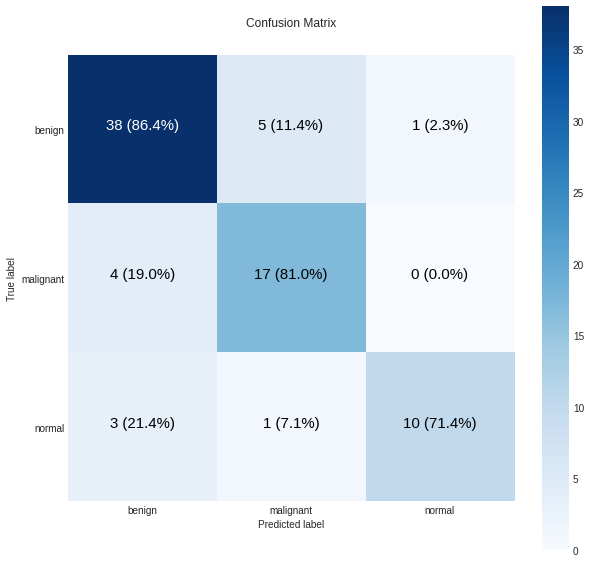

In [ ]:
make_confusion_matrix(y_true=true_labels,
                      y_pred=predictions,
                      classes=test_generator.class_indices,
                      figsize=(10,10),
                      text_size=15)

In [ ]:
from sklearn.metrics import classification_report

num_of_train_samples = 703
num_of_test_samples = 77
batch_size = 16

Y_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

5/5 [==============================] - 2s 282ms/step
Classification Report
              precision    recall  f1-score   support

      benign       0.84      0.86      0.85        44
   malignant       0.74      0.81      0.77        21
      normal       0.91      0.71      0.80        14

    accuracy                           0.82        79
   macro avg       0.83      0.80      0.81        79
weighted avg       0.83      0.82      0.82        79



5/5 [==============================] - 1s 179ms/step


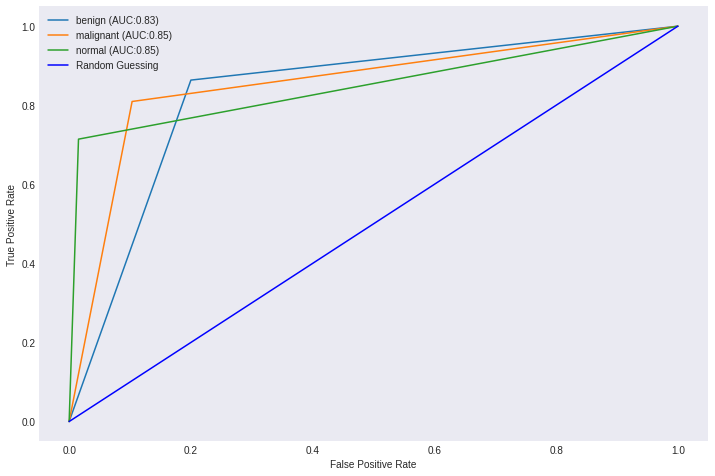

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names): 
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

test_generator.reset() 
y_pred = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
model.save_weights('model_simple_weights_2.h5')
model.save('model_skenario_2.h5')